### init.

In [1]:
% matplotlib inline
import sqlite3
import pandas as pd
import networkx as nx
import xlrd
import matplotlib.pyplot as plt
import math
import warnings
from tqdm import tqdm
import re
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('20170424CBDBauUserSqlite.db')

#### Prepare codebook.

In [ ]:
# Extract all table names and variables.
table_list=pd.read_sql_query("SELECT name FROM sqlite_master", conn)

table_list['name']=table_list['name'].apply(str.upper)
table_list['explanation_en']=''
table_list['explanation_cn']=''
table_list.rename(columns={'name':'table_code'}, inplace=True)

writer = pd.ExcelWriter('cbdb_codebook.xlsx', engine = 'xlsxwriter')
table_list.to_excel(writer, sheet_name='TABLE_LIST', encoding='utf8', index=False)

for table in table_list['table_code']:
    table_columns=pd.read_sql_query("SELECT * FROM "+table, conn).columns
    df_temp=pd.DataFrame()
    df_temp['column_code']=table_columns
    df_temp['meaning_cn']=''
    df_temp['meaning_en']=''
    df_temp['data_type']=''
    df_temp['note']=''
    df_temp.to_excel(writer, sheet_name=table[0:31], encoding='utf8', index=False)

writer.save()
writer.close()

In [ ]:
# Add new columns.
writer = pd.ExcelWriter('cbdb_codebook.xlsx', engine = 'xlsxwriter')
sheet_names=xlrd.open_workbook('cbdb_codebook_temp.xlsx', on_demand=True).sheet_names()

for sheet_nm in sheet_names:
    df_temp=pd.read_excel('cbdb_codebook_temp.xlsx', sheetname=sheet_nm)
    df_temp.rename(columns={'note':'coded'}, inplace=True)
    df_temp['code_table']=''
    df_temp['note']=''
    df_temp.to_excel(writer, sheet_name=sheet_nm, encoding='utf8', index=False)

writer.save()
writer.close()

#### SNA.

In [2]:
# ASSOC_DATA(c_assoc_code) --> ASSOC_CODE_TYPE_REL(c_assoc_type_id) --> ASSOC_TYPES(c_assoc_type_desc)
def assoc_typeid2desc(c_assoc_type_id):
    return df_assoc_types.loc[c_assoc_type_id]['c_assoc_type_desc']
def assoc_code2desc(c_assoc_code):
    try:
        return assoc_typeid2desc(df_assoc_code_type_rel.loc[c_assoc_code]['c_assoc_type_id'])
    except:
        return 99999

def index_year(c_personid):
    return df_biog_main.loc[c_personid]['c_index_year']

def personid2name(c_personid):
    return df_biog_main.loc[c_personid]['c_name']

In [3]:
db_file_list=['20170424CBDBauUserSqlite.db', 'sqlite_20180302.db']
df_assoc_ptg_list=[]
for db_file in db_file_list:
    conn = sqlite3.connect(db_file)

    df_assoc_types=pd.read_sql_query("SELECT * FROM ASSOC_TYPES", conn).set_index('c_assoc_type_id')
    df_assoc_code_type_rel=pd.read_sql_query("SELECT * FROM ASSOC_CODE_TYPE_REL", conn).set_index('c_assoc_code')
    df_biog_main=pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn).set_index('c_personid')
    df_assoc_data=pd.read_sql_query("SELECT * FROM ASSOC_DATA", conn)

    g=nx.Graph()
    error_index=[]
    for index in tqdm(df_assoc_data.index):
        try:
            g.add_edge(str(df_assoc_data.loc[index]['c_personid'])+'_'+str(personid2name(df_assoc_data.loc[index]['c_personid'])), 
                       str(df_assoc_data.loc[index]['c_assoc_id'])+'_'+str(personid2name(df_assoc_data.loc[index]['c_assoc_id'])),
                       assoc_type_desc=assoc_code2desc(df_assoc_data.loc[index]['c_assoc_code']),
                       index_year_average=(index_year(df_assoc_data.loc[index]['c_personid'])+index_year(df_assoc_data.loc[index]['c_assoc_id']))/2)
        except:
            error_index.append(index)

    # Some personid in df_assoc_data is not in df_biog_main, e.g., .

    df_index_yr_assoc_type=pd.concat([pd.DataFrame(list(nx.get_edge_attributes(g, 'index_year_average').items()), columns=['edge', 'index_yr_average']).set_index('edge'), 
                                      pd.DataFrame(list(nx.get_edge_attributes(g, 'assoc_type_desc').items()), columns=['edge', 'assoc_type_desc']).set_index('edge')], axis=1)
    df_index_yr_assoc_type['observed']=1
    df_index_yr_assoc_type.reset_index(inplace=True)

    df_index_yr_assoc_type['index_yr_average'].fillna(9999, inplace=True)
    df_index_yr_assoc_type['centennial']=(df_index_yr_assoc_type['index_yr_average']/100).apply(int)*100
    df_index_yr_assoc_type.replace(9900, math.nan, inplace=True)
    df_cent_agg=df_index_yr_assoc_type.groupby('centennial').count()[['observed']]
    df_assoc_ptg=df_index_yr_assoc_type.groupby(['centennial', 'assoc_type_desc']).count()[['observed']].reset_index()

    for index in tqdm(df_assoc_ptg.index):
        cent=df_assoc_ptg.loc[index]['centennial']
        df_assoc_ptg.loc[index, 'ptg']=df_assoc_ptg.loc[index]['observed']/df_cent_agg.loc[cent]['observed']

    df_assoc_ptg.set_index('centennial', inplace=True)
    df_assoc_ptg_list.append(df_assoc_ptg)

100%|██████████| 371/371 [00:00<00:00, 975.30it/s]


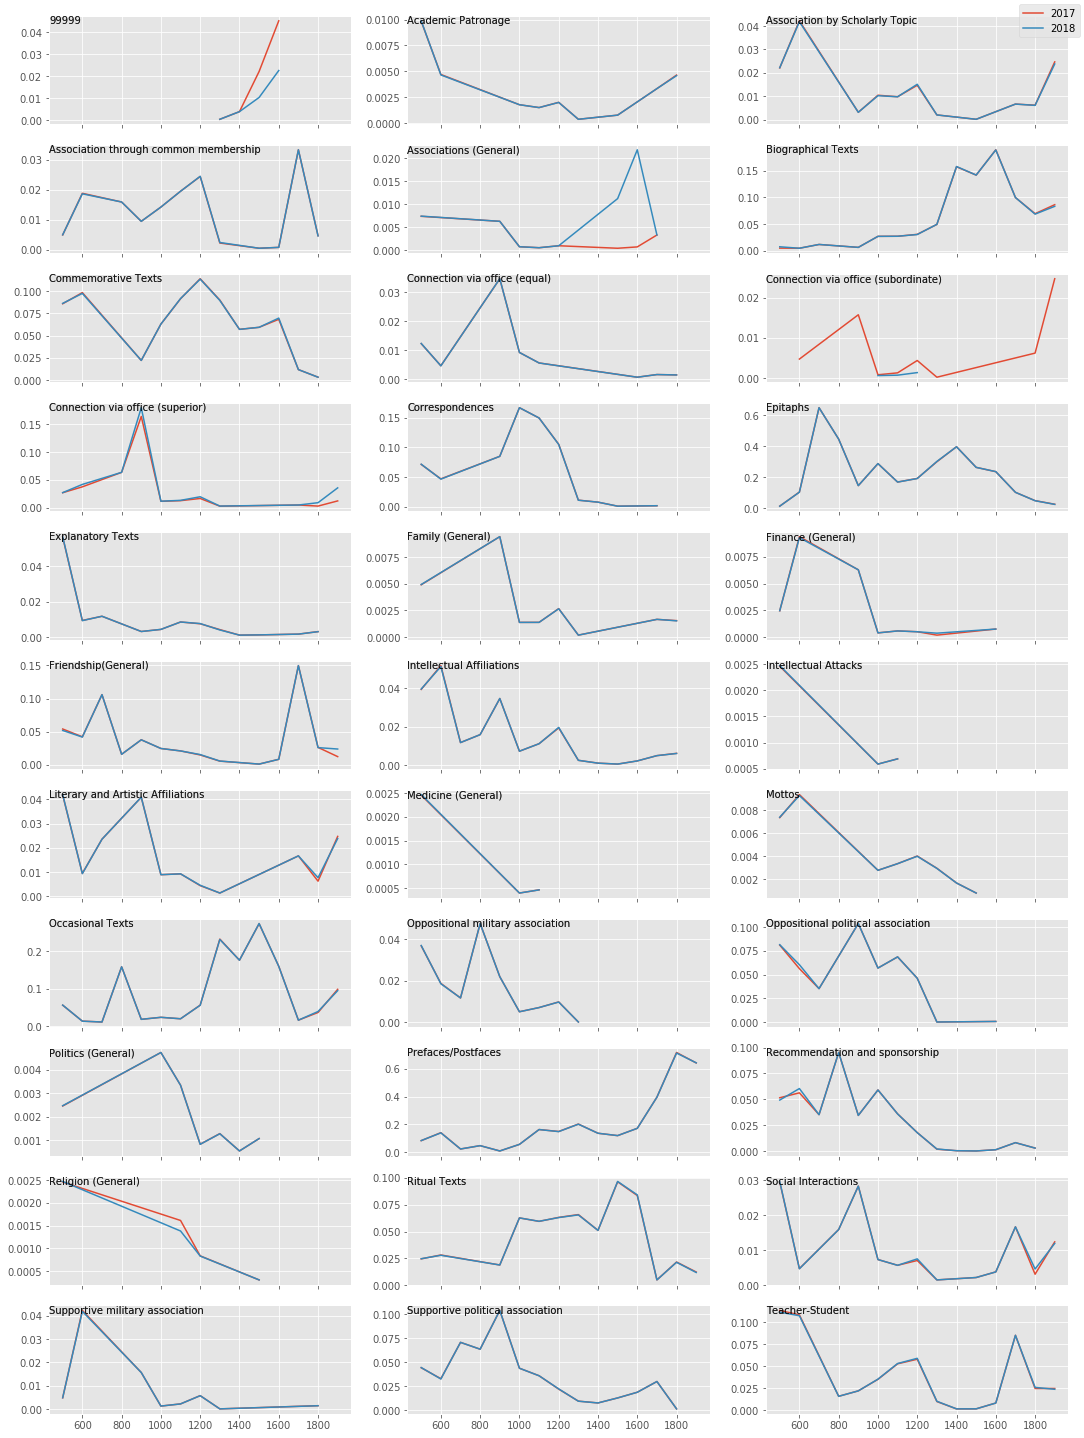

In [119]:
fig=plt.figure()
fig.set_size_inches(15, 20)
axes=fig.subplots(sharex='all', ncols=3, nrows=11).flatten()
year=2017
for df_assoc_ptg in df_assoc_ptg_list:
    i=0
    for label, grp in df_assoc_ptg.loc[500:].groupby('assoc_type_desc'):
        ax=axes[i]
        ax.plot(grp.index, grp['ptg'], label=str(year))
        ax.text(0, 1, label, ha='left', va='top', transform = ax.transAxes, alpha=0.7)
        #ax.legend(loc=1)
        i+=1
    year+=1
fig.legend(loc=1)
fig.tight_layout()
fig.savefig('assoc_type_20170424_20180302.pdf')

In [54]:
df_index_yr_assoc_type.groupby(['centennial', 'assoc_type_desc']).count().reset_index().set_index('centennial')[['assoc_type_desc','observed']].to_excel('plot_test.xlsx')

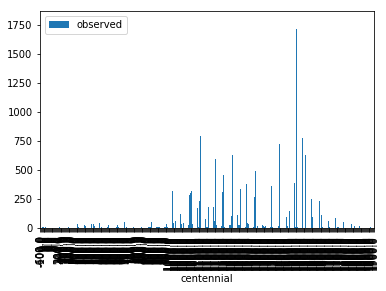

In [52]:
df_index_yr_assoc_type.groupby(['centennial', 'assoc_type_desc']).count().reset_index().set_index('centennial')[['assoc_type_desc','observed']].plot.bar(stacked=True)

In [112]:
df_office_categories=pd.read_sql_query("SELECT * FROM OFFICE_CATEGORIES", conn)

In [116]:
for i in df_office_categories['c_notes']:
    print(i)

None
from Kracke, "Translation of Sung Civil Service Titles"
Used in the Song before 1080, from Kracke, "Translation of Sung Civil Service Titles"
from Kracke, "Translation of Sung Civil Service Titles"
12 honorific titles, from Kracke, "Translation of Sung Civil Service Titles"
19 titular offices, from Kracke, "Translation of Sung Civil Service Titles"
After 1080, the title suggests the function, includes a number of the chaiqian office, from Kracke, "Translation of Sung Civil Service Titles"
Used before 1080, from Kracke, "Translation of Sung Civil Service Titles"
from Kracke, "Translation of Sung Civil Service Titles"
from Kracke, "Translation of Sung Civil Service Titles"
Before 1080 denotes rank, after 1080 denotes actual position.
ALways used to define rank for salary purposes
None
c_notes from Hucker,  used for eminent official appointed to academic status position
used for appointments that are concurrent with the posting noted in source


In [27]:
for index in tqdm(df_index_yr_assoc_type.index):
    iya=df_index_yr_assoc_type.loc[index]['index_yr_average']
    if not math.isnan(iya):
        df_index_yr_assoc_type.loc[index]['centennial']=int(iya/100)*100
    else:
        pass # default to nan.

  2%|▏         | 722/46777 [01:23<1:29:15,  8.60it/s]

KeyboardInterrupt: 

In [215]:
df_index_yr_assoc_type

('13_Chao Buzhi', '3021_Chao Zongjian')

In [195]:
df_index_yr_assoc_type.to_excel('test.xlsx')

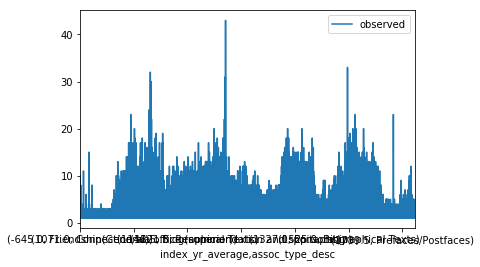

In [197]:
df_index_yr_assoc_type.groupby(['index_yr_average', 'assoc_type_desc']).count().plot()

In [ ]:
df_index_yr_assoc_type.groupby('index_yr_average').count()['edge'].loc[500:].plot()
plt.savefig('sna_test2.png')

### Office title Qing.

In [13]:
df_office_qing=pd.read_sql_query("SELECT * FROM OFFICE_CODES", conn)[pd.read_sql_query("SELECT * FROM OFFICE_CODES", conn).c_dy==20]
df_office_qing_drop_col=df_office_qing[['c_office_id', 'c_office_chn']]
df_office_qing_drop_col.sample(5)

,c_office_id,c_office_chn
25428,87904,總署大臣
19045,81519,奉書前引大臣
21487,83962,路總兵官
18941,81415,翻譯鄉試副考官
22117,84592,清漪園六品苑丞


In [14]:
len(df_office_qing_drop_col)

8033

In [5]:
df_qing_ihp_local=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9vkei7bcm7RMuXRT1A8r6BIlJk3KO3o6sWKCGikiEX7EL7ZAsXZo9e3HetSw825scdJ97PrjDMuPp/pub?gid=8671972&single=true&output=tsv',
                        sep='\t'
                       )
df_qing_ihp_local[['Place', 'Office', 'Title']].sample(3)

,Place,Office,Title
529,安徽,NaN,提學使
46,福建,NaN,驛鹽道
60,江蘇,NaN,按察使


In [6]:
df_qing_ihp_cent=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9vkei7bcm7RMuXRT1A8r6BIlJk3KO3o6sWKCGikiEX7EL7ZAsXZo9e3HetSw825scdJ97PrjDMuPp/pub?gid=281756084&single=true&output=tsv',
                             sep='\t'
                            )
df_qing_ihp_cent[['Office', 'Title']].sample(3)

,Office,Title
1248,前所,掌所印冠軍使
9930,黃冊房,署正
3077,寺庫,庫使


In [7]:
place_set=set(s for s in df_qing_ihp_local.Place.dropna().unique())
office_set=set([s for s in df_qing_ihp_local.Office.dropna().unique()]+[s for s in df_qing_ihp_cent.Office.dropna().unique()])
title_set=set([s for s in df_qing_ihp_local.Title.dropna().unique()]+[s for s in df_qing_ihp_cent.Title.dropna().unique()])

In [8]:
df_office_qing_drop_col=df_office_qing_drop_col.sample(1000)
for index in tqdm(df_office_qing_drop_col.index):
    c_office_chn=df_office_qing_drop_col.loc[index, 'c_office_chn']
    place_list=[]
    for place in place_set:
        if place in c_office_chn:
            place_list.append(place)
    df_office_qing_drop_col.loc[index, 'place']='#'.join(place_list)
    office_list=[]
    for office in office_set:
        if office in c_office_chn:
            office_list.append(office)
    df_office_qing_drop_col.loc[index, 'office']='#'.join(office_list)
    title_list=[]
    for title in title_set:
        if c_office_chn.endswith(title):
            title_list.append(title)
    df_office_qing_drop_col.loc[index, 'title']='#'.join(title_list)

100%|██████████| 1000/1000 [00:03<00:00, 322.73it/s]


In [12]:
df_office_qing_drop_col.to_csv('dump/df_office_qing_drop_col.tsv', sep='\t')

In [9]:
splitting_token_list=set(['武選司', '雲南司', '太僕寺', '捷報處', 
                          '捷報處', '武庫清吏司', '武選清吏司','清檔房',
                          '漢本房', '當月處', '司務廳','吏部','收發處',
                          '學治館','文選清吏司','清檔房','漢本房','當月處','督催所','稽勳清吏司',
                          '主客清吏司','儀制清吏司','光祿司','光祿寺','南庫','參議廳','司務廳','和聲署','國子監','地租處',
                          '司務廳','吏部','收發處','學治館','文選清吏司','清檔房','漢本房','當月處','督催所','稽勳清吏司','主客清吏司',
                          '儀制清吏司','光祿司','光祿寺','南庫','參議廳','司務廳','和聲署','國子監','地租處','刑部','司務廳','四川清吏司',
                          '奉天清吏司','安徽清吏司','山東清吏司','山西清吏司','廣東清吏司','廣西清吏司','律例館','提牢廳','江南清吏司','江蘇清吏司',
                          '江西清吏司','河南清吏司','浙江清吏司','清檔房','減等處','湖廣清吏司','漢檔房','現審右司','現審左司','當月處',
                          '直隸清吏司','督催所','督捕前司','督捕廳','督捕後司','督捕清吏司','福建清吏司','秋審處','科抄房','貴州清吏司',
                          '贓罰庫','贖罪處','陝西清吏司','雲南清吏司','飯銀處',
                        ])
df_c_office_chn_splite=pd.DataFrame()
c_office_id_split_container=[]
for index in df_office_qing_drop_col.index:
    c_office_chn=df_office_qing_drop_col.loc[index, 'c_office_chn']
    c_office_id=df_office_qing_drop_col.loc[index, 'c_office_id']
    if c_office_id not in c_office_id_split_container:
        for splitting_token in splitting_token_list:
            if splitting_token in c_office_chn:
                c_office_chn_splite_list=c_office_chn.split(splitting_token)+[splitting_token]
                atom_list=['']*(len(c_office_chn_splite_list)-1)+['O']
                df_temp=pd.DataFrame()
                df_temp['c_office_chn_splite']=c_office_chn_splite_list
                df_temp['atom']=atom_list
                df_temp['c_office_chn']=c_office_chn
                df_temp['c_office_id']=c_office_id
                df_c_office_chn_splite=pd.concat([df_c_office_chn_splite, df_temp])
                c_office_id_split_container.append(c_office_id)
df_c_office_chn_splite.reset_index(inplace=True, drop=True)

In [10]:
df_c_office_chn_splite

,c_office_chn_splite,atom,c_office_chn,c_office_id
0,兵部,,兵部漢本房總辦,80379
1,總辦,,兵部漢本房總辦,80379
2,漢本房,O,兵部漢本房總辦,80379
3,兵部,,兵部捷報處員外郎,80381
4,員外郎,,兵部捷報處員外郎,80381
5,捷報處,O,兵部捷報處員外郎,80381
6,兵部,,兵部捷報處章京,80382
7,章京,,兵部捷報處章京,80382
8,捷報處,O,兵部捷報處章京,80382
9,兵部,,兵部司務廳領班,80398


In [7]:
df_c_office_chn_splite.to_excel('df_c_office_chn_splite.xlsx', encoding='utf8')

### Song Biomain, last name Zhao (two characters).

In [17]:
# Get all Song bios.
df_bio_song=pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn)[pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn).c_dy==19]

In [18]:
len(df_bio_song)

163730

In [14]:
# Get all Song bios.
df_bio_song=pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn)[pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn).c_dy==15]

In [15]:
df_bio_song

,tts_sysno,c_personid,c_name,c_name_chn,c_index_year,c_female,c_ethnicity_code,c_household_status_code,c_tribe,c_birthyear,...,c_mingzi_proper,c_name_proper,c_surname_rm,c_mingzi_rm,c_name_rm,c_created_by,c_created_date,c_modified_by,c_modified_date,c_self_bio
0,1.0,1,An Dun,安惇,1101.0,0,0.0,0.0,None,1042.0,...,None,None,None,None,None,TTS,20070312,BDNWH,20081018,1
1,2.0,2,An Fang,安邡,1136.0,0,0.0,0.0,None,0.0,...,None,None,None,None,None,TTS,20070312,None,None,0
2,3.0,3,An Tao,安燾,1102.0,0,0.0,0.0,None,NaN,...,None,None,None,None,None,TTS,20070312,BDNWH,20081018,1
3,4.0,4,Zha Dao,查道,1014.0,0,0.0,0.0,None,955.0,...,None,None,None,None,None,TTS,20070312,BDLYH,20080121,1
4,5.0,5,Zha Yue,查籥,1181.0,0,0.0,0.0,None,0.0,...,None,None,None,None,None,TTS,20070312,BDLYH,20080122,1
5,6.0,6,Chai Chengwu,柴成務,993.0,0,0.0,0.0,None,934.0,...,None,None,None,None,None,TTS,20070312,BDGSX,20080114,1
6,7.0,7,Chai Tianyin,柴天因,1130.0,0,0.0,0.0,None,0.0,...,None,None,None,None,None,TTS,20070312,None,None,0
7,8.0,8,Chang Jin,常僅,1134.0,0,0.0,0.0,None,0.0,...,None,None,None,None,None,TTS,20070312,None,None,0
8,9.0,9,Chang Renzhi,常任秩,1142.0,0,0.0,0.0,None,0.0,...,None,None,None,None,None,TTS,20070312,None,None,0
9,10.0,10,Chao Qianzhi,晁謙之,1154.0,0,0.0,0.0,None,NaN,...,None,None,None,None,None,TTS,20070312,BDZWZ,20080618,1


In [16]:
df_bio_song.loc[[index for index in df_bio_song.index if len(str(re.findall(r'\w+', df_bio_song.loc[index]['c_name_chn'])[0]))==3 
                 and str(re.findall(r'\w+', df_bio_song.loc[index]['c_name_chn'])[0]).startswith('趙')]
               ].to_excel('dump/song_biomain_Zhao_3chr_name.xlsx', encoding='utf8')

### Tang Biomain.

In [15]:
# Get all Tang bios.
df_bio_tang=pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn)[pd.read_sql_query("SELECT * FROM BIOG_MAIN", conn).c_dy==6]
df_bio_tang.to_excel('dump/df_bio_tang.xlsx', encoding='utf8')

In [13]:
# Get the dynasty code and name.
pd.read_sql_query("SELECT * FROM DYNASTIES", conn)

,c_dy,c_dynasty,c_dynasty_chn,c_start,c_end,c_sort
0,0,unknown,未詳,0,0,0.0
1,1,Pre-Han,漢前,-1100,-206,1.0
2,2,QinHan,秦漢,-221,220,2.0
3,3,SanGuo,三國,220,265,7.0
4,4,NanBei Chao,南北朝,420,589,13.0
5,5,Sui,隋,581,618,41.0
6,6,Tang,唐,618,907,42.0
7,7,Five Dynasties,五代,907,960,44.0
8,8,Later Shu (10 states),後蜀,933,965,52.0
9,9,Wu,吳,904,937,77.0


In [19]:
# Get text id and name table.
pd.read_sql_query("SELECT * FROM TEXT_CODES", conn).to_excel('dump/df_text_codes.xlsx', encoding='utf8')

In [20]:
# Get text id and name table.
pd.read_sql_query("SELECT * FROM BIOG_SOURCE_DATA", conn).to_excel('dump/df_bio_source_data.xlsx', encoding='utf8')